<a href="https://colab.research.google.com/github/JHyunjun/SNU/blob/main/RNNREC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preprocessing settings

In [86]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
in_path = '/content/drive/MyDrive/Colab Notebooks/snu/w4/실습자료/7-28 rnnrec-movielens/data/ml-1m-raw/'
ratings_file = in_path + 'ratings.dat'

## Load data file

In [88]:
# Load the input file in memory
raw = []
with open(ratings_file, 'r') as f_read:
    for line in f_read.readlines():
        line_list = line.split('::')
        raw.append(line_list)

## Data's skewness

users` max freq: 2314
items` max freq: 3428


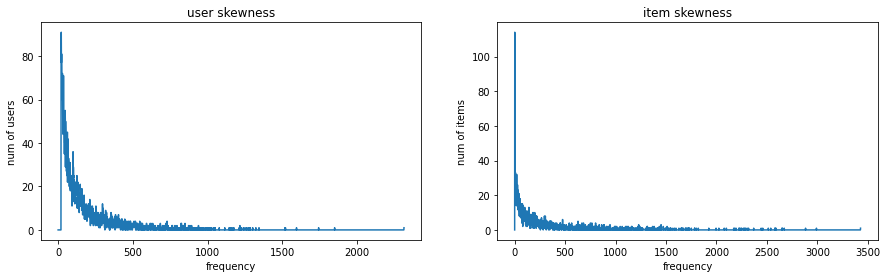

In [89]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,4)

raw = np.array(raw, dtype=int)
# user가 몇개의 item에 대해 rating을 매겼는지, 이걸 bincount함수로 반환함
user_freq = np.bincount(raw[:, 0]) # [user1's freq, user2's freq, ..., usern's freq]
user_freq = [i for i in user_freq if i>0] # exclude dummy users
user_freq = np.bincount(user_freq)
user_x_axis = np.array(range(len(user_freq)))
print(f'users` max freq: {len(user_freq)-1}')

item_freq = np.bincount(raw[:, 1]) #[item1's freq, item2's freq, ..., itemm's freq]
item_freq = [i for i in item_freq if i>0] # exclude dummy items
item_freq = np.bincount(item_freq)
item_x_axis = np.array(range(len(item_freq)))
print(f'items` max freq: {len(item_freq)-1}')

fig, axs = plt.subplots(1, 2)
axs[0].plot(user_x_axis, user_freq)
axs[0].set_title('user skewness')
axs[0].set_xlabel('frequency')
axs[0].set_ylabel('num of users')
axs[1].plot(item_x_axis, item_freq)
axs[1].set_title('item skewness')
axs[1].set_xlabel('frequency')
axs[1].set_ylabel('num of items')
plt.show()

In [90]:
#예시, 1번유저 1개, 2번유저 3개 ...
A = np.array([1,2,2,2,4,4,4,4,5,5,5,5,5])
A = np.bincount(A)
print(A) # 각 user별 rating 매긴 횟수
B = np.bincount(A)
print(B) # 1개 rating을 준사람, 2개 rating을 준사람

[0 1 3 0 4 5]
[2 1 0 1 1 1]


In [91]:
print(user_freq)

[0 0 0 ... 0 0 1]


## Sort interactions by (u_id, time)

In [92]:
# user id : x[0], time stamp : x[3]대로 sorting
raw_sorted = np.array(sorted(raw, key=lambda x: (x[0], x[3])))
print(f'num of interactions: {len(raw_sorted)}')
print(raw_sorted)

num of interactions: 1000209
[[        1      3186         4 978300019]
 [        1      1270         5 978300055]
 [        1      1721         4 978300055]
 ...
 [     6040      1784         3 997454464]
 [     6040       161         3 997454486]
 [     6040      1221         4 998315055]]


## Assign new ids

In [93]:
# 0번부터 Dense하게 user/item을 정렬하도록
user_ids = list()
item_ids = list()
user_map = dict() # raw -> new
item_map = dict() # raw -> new

user_ids = np.unique(raw[:, 0])
item_ids = np.unique(raw[:, 1])

user_map = {v: i for (i, v) in enumerate(user_ids)}
item_map = {v: i for (i, v) in enumerate(item_ids)}

new_sorted = [[user_map[u], item_map[i]] for (u, i)
              in zip(raw_sorted[:, 0], raw_sorted[:, 1])] # user map, item map을 이용해서 element wise로 raw sorted[:,0], [:,1]을 정리

In [94]:
print(new_sorted) # User id/Item id만 있음

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Construct dictionary of side information

In [95]:
movies_file = in_path + 'movies.dat'
meta_dict = dict() # User의 정보 : 좋아하는 장르, 이 코드에선 검증용도로만 사용(추천한 영화의 장르와 선호 장르가 동일한지)
        
with open(movies_file, 'r',  encoding='ISO-8859-1') as f_read:
    for line in f_read.readlines():
        line_list = line.split('::')
        raw_id = int(line_list[0].strip())
        try:
            new_id = item_map[raw_id]
        except KeyError:
            continue
        meta_dict[new_id] = [line_list[1].strip(), line_list[2].strip()]

## Construct train/test lists

In [96]:
ratio = 0.8

In [97]:
new_sorted = np.array(new_sorted)
#np.diff : 이전것과 그다음것의 차이를 return = 0이아니면 다른 유저라고 볼수있음
split_idx = np.flatnonzero(np.diff(new_sorted[:, 0])) + 1 #어느부분을 split을 할지 찾는것, User별 split한 구간 찾음

In [98]:
print(split_idx)

[    53    182    233 ... 999725 999745 999868]


In [99]:
print(new_sorted.shape) #[1000209,2]
print(new_sorted)

(1000209, 2)
[[   0 2969]
 [   0 1178]
 [   0 1574]
 ...
 [6039 1618]
 [6039  155]
 [6039 1131]]


In [100]:
#유저별로 나누고, ratio로 분할
trn_list, test_list = [], []
for arr in np.array_split(new_sorted, split_idx): #new_sorted를 split_idx대로 쪼개서 list로 return
  split_i = round(len(arr) * ratio)
  trn_list.append(arr[:split_i, :])
  test_list.append(arr[split_i:, :])

In [101]:
trn_arr = np.concatenate(trn_list, axis=0)
test_arr = np.concatenate(test_list, axis=0)

In [102]:
print(trn_arr)

[[   0 2969]
 [   0 1178]
 [   0 1574]
 ...
 [6039 2111]
 [6039 3107]
 [6039  256]]


In [103]:
print(test_arr)

[[   0  581]
 [   0 2483]
 [   0  708]
 ...
 [6039 1618]
 [6039  155]
 [6039 1131]]


## Data instance parameters

In [104]:
feed_len = 5
target_len = 3
neg_samples = 100

## Make data instances

In [105]:
"""
If user 0 interacted with items [1, 2, 3, 4, 5, 6, 7, 8, 9],
the returned interactions matrix at sequence lenght 5 and target length 3 will be:

trn_users:
[0, 0]

trn_feed_sequences:
[[1, 2, 3, 4, 5],
 [2, 3, 4, 5, 6]]

trn_positive_targets:
 [[6, 7, 8],
  [7, 8, 9]]

test_feed_sequences:
 [[5, 6, 7, 8, 9]]
"""
# instance 7개 생성

trn_users = []
trn_feed_sequences = []
trn_positive_targets = []
trn_negative_targets = [] #random으로 negative sampling
test_users = []
test_feed_sequences = []
test_targets = []

In [106]:
for trn_arr, test_arr in zip(trn_list, test_list): #User 1명에 대한 내용
  # numpy의 sliding_window
  trn_split = np.lib.stride_tricks.sliding_window_view(trn_arr, window_shape=feed_len+target_len, axis=0)
  trn_users.append(trn_split[:, 0, 0])
  trn_feed_sequences.append(trn_split[:, 1, :feed_len])
  trn_positive_targets.append(trn_split[:, 1, feed_len:])
  test_feed_sequences.append(trn_arr[-feed_len:, 1])
  trn_negative_targets.append(np.random.randint(len(item_map), size=(trn_split.shape[0], neg_samples))) # Negative Sampling Random하게

  test_users.append(test_arr[0, 0])
  test_target_sequence = test_arr[:, 1]
  test_targets.append(test_target_sequence)

In [107]:
print(trn_split.shape) #[266,2,8]
print(trn_split)

(266, 2, 8)
[[[6039 6039 6039 ... 6039 6039 6039]
  [ 802  579 2191 ...  559 1316  207]]

 [[6039 6039 6039 ... 6039 6039 6039]
  [ 579 2191 1781 ... 1316  207 2895]]

 [[6039 6039 6039 ... 6039 6039 6039]
  [2191 1781 1839 ...  207 2895 3272]]

 ...

 [[6039 6039 6039 ... 6039 6039 6039]
  [3493 3441 1124 ... 1342 3271 2111]]

 [[6039 6039 6039 ... 6039 6039 6039]
  [3441 1124 2410 ... 3271 2111 3107]]

 [[6039 6039 6039 ... 6039 6039 6039]
  [1124 2410 2443 ... 2111 3107  256]]]


In [108]:
print(test_users)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [109]:
trn_users = np.concatenate(trn_users)
trn_feed_sequences = np.concatenate(trn_feed_sequences, axis=0)
trn_positive_targets = np.concatenate(trn_positive_targets, axis=0)
trn_negative_targets = np.concatenate(trn_negative_targets, axis=0)
test_users = np.array(test_users)
test_feed_sequences = np.stack(test_feed_sequences)

x_train = np.concatenate((trn_users[:, np.newaxis], trn_feed_sequences), axis=1) 
x_test = np.concatenate((test_users[:, np.newaxis], test_feed_sequences), axis=1)
idx_train = np.concatenate((trn_positive_targets, trn_negative_targets), axis=1)

In [110]:
print(x_train)
print('/')
print(x_test)

[[   0 2969 1178 1574  957 2147]
 [   0 1178 1574  957 2147 1658]
 [   0 1574  957 2147 1658 3177]
 ...
 [6039 3493 3441 1124 2410 2443]
 [6039 3441 1124 2410 2443 1342]
 [6039 1124 2410 2443 1342 3271]]
/
[[   0 1107  580 2205 1421  513]
 [   1 1826 2086 1271  627 2234]
 [   2 3189 1295 2785 1212 3379]
 ...
 [6037 2872  225 1059 1133 1204]
 [6038  740 1011 1314  193   47]
 [6039 1342 3271 2111 3107  256]]


## Model parameters

In [111]:
lr = 1e-3
batch_size = 1000
epochs = 10
emb_dim = 50
hid_dim = 50
epsilon = 1e-10 # This prevents the occurrence of log(0)

## Define a model



In [112]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, multiply, Dense, Embedding, LSTM, concatenate, dot

class my_model(tf.keras.Model):
    def __init__(self, num_items, num_users, emb_dim, hid_dim, feed_len, target_len, epsilon):
        super(my_model, self).__init__(self)
        self.epsilon = epsilon
        self.item = Embedding(num_items, emb_dim, input_length = feed_len)
        self.user = Embedding(num_users, emb_dim)
        self.lstm = LSTM(units = hid_dim)
        #여기까진 LSTM output이고 
        self.lstm_dense = Dense(emb_dim)
        self.final1 = Dense(emb_dim, activation = 'relu')
        self.final2 = Dense(num_items)
   
    def call(self, x):
        user = x[:, 0]
        item = x[:, 1:]
        item_out = self.lstm_dense(self.lstm(self.item(item)))
        user_embedding = self.user(user)
        concat = concatenate([item_out, user_embedding])
        model_out = self.final2(self.final1(concat))
        return model_out

model = my_model(len(item_map), len(user_map), emb_dim, hid_dim, feed_len, target_len, epsilon)

In [113]:
def rec_loss(idx, y_pred):
  # idx : 103개 item만 가지고옴
    logits = tf.gather(y_pred, idx, axis = 1, batch_dims = 1)
    #앞에 3개를 positive logits으로, 뒤에 100개를 negativs logits으로
    pos_logits, neg_logits = logits[:, :target_len], logits[:, target_len:]
    #clip_value로 epsilon ~ 1 제한
    pos_loss = -tf.math.reduce_sum(tf.math.log(tf.clip_by_value(tf.math.sigmoid(pos_logits), clip_value_min = epsilon, clip_value_max = 1)), axis = 1)
    neg_loss = -tf.math.reduce_sum(tf.math.log(tf.clip_by_value(1 - tf.math.sigmoid(neg_logits), clip_value_min = epsilon, clip_value_max = 1)), axis = 1)
    return tf.math.reduce_mean(pos_loss + neg_loss) #[batch,1]

In [114]:
model.compile(optimizer='adam', loss=rec_loss)

## Train the model

In [115]:
model.fit(x_train, idx_train, epochs=epochs, batch_size=batch_size)

Epoch 1/10
758/758 [==============================] - 14s 8ms/step - loss: 13.6710
Epoch 2/10
758/758 [==============================] - 7s 9ms/step - loss: 11.0937
Epoch 3/10
758/758 [==============================] - 6s 7ms/step - loss: 10.2098
Epoch 4/10
758/758 [==============================] - 6s 8ms/step - loss: 8.7789
Epoch 5/10
758/758 [==============================] - 7s 9ms/step - loss: 7.8837
Epoch 6/10
758/758 [==============================] - 5s 7ms/step - loss: 7.4040
Epoch 7/10
758/758 [==============================] - 6s 8ms/step - loss: 7.0554
Epoch 8/10
758/758 [==============================] - 5s 7ms/step - loss: 6.8049
Epoch 9/10
758/758 [==============================] - 6s 7ms/step - loss: 6.6045
Epoch 10/10
758/758 [==============================] - 8s 11ms/step - loss: 6.4457


## Evaluate the model

In [116]:
def compute_precision(predictions, targets, k):
    pred = predictions[:k]
    num_hit = len(set(pred).intersection(set(targets)))
    return float(num_hit) / len(pred)

def compute_recall(predictions, targets, k):
    pred = predictions[:k]
    num_hit = len(set(pred).intersection(set(targets)))
    return float(num_hit) / len(targets)

def compute_ap(predictions, targets, k):
    if len(predictions) > k:
        predictions = predictions[:k]
    score = 0.
    num_hits = 0.
    for i, p in enumerate(predictions):
        if p in targets:
            num_hits += 1.
            score += num_hits / (i+1)
    return score / min(len(targets), k)

def evaluate(preds, gts, k=10):
    precs = [compute_precision(p, t, k=k) for (p, t) in zip(preds, gts)]
    recalls = [compute_recall(p, t, k=k) for (p, t) in zip(preds, gts)]
    aps = [compute_ap(p, t, k=k) for (p, t) in zip(preds, gts)]
    return float(sum(precs) / len(precs)), \
            float(sum(recalls) / len(recalls)), \
            float(sum(aps) / len(aps))

In [117]:
preds = tf.argsort(-model.call(x_test)).numpy()
prec, recall, ap = evaluate(preds, test_targets, k=10)
print(f'Prec@10: {prec:.4f}, Recall@10: {recall:.4f}, Map@10: {ap:.4f}')

Prec@10: 0.1293, Recall@10: 0.0844, Map@10: 0.0646


## Qualitative evaluation

In [118]:
from random import randint
idx = randint(0, len(test_users))
history = [meta_dict[i] for i in test_feed_sequences[idx]]
predict = [meta_dict[i] for i in preds[idx][:10]]
real = [meta_dict[i] for i in test_targets[idx]]

def mask2str(mask):
    return 'O' if mask else 'X'

predict_mask = [check in test_targets[idx] for check in preds[idx][:10]]
real_mask = [check in preds[idx][:10] for check in test_targets[idx]]
predict_mask = [mask2str(mask) for mask in predict_mask]
real_mask = [mask2str(mask) for mask in real_mask]

print('==== Watched history ====')
for i in history:
    print(i)
    
print('==== Real targets ===')
for m, v in zip(real_mask, real):
    print(f'{[m]} {v}')


print('=== Predicted targets ===')
for m, v in zip(predict_mask, predict):
    print(f'{[m]} {v}')

==== Watched history ====
['Good, The Bad and The Ugly, The (1966)', 'Action|Western']
['Dirty Dozen, The (1967)', 'Action|War']
['Unforgiven (1992)', 'Western']
['Outlaw Josey Wales, The (1976)', 'Western']
['High Plains Drifter (1972)', 'Western']
==== Real targets ===
['O'] ['Pale Rider (1985)', 'Western']
['O'] ["Hang 'em High (1967)", 'Western']
['X'] ['Tombstone (1993)', 'Western']
['X'] ['Legends of the Fall (1994)', 'Drama|Romance|War|Western']
=== Predicted targets ===
['X'] ['High Plains Drifter (1972)', 'Western']
['X'] ['For a Few Dollars More (1965)', 'Western']
['X'] ['Outlaw Josey Wales, The (1976)', 'Western']
['O'] ['Pale Rider (1985)', 'Western']
['X'] ['Good, The Bad and The Ugly, The (1966)', 'Action|Western']
['X'] ['Magnum Force (1973)', 'Western']
['O'] ["Hang 'em High (1967)", 'Western']
['X'] ['Fistful of Dollars, A (1964)', 'Action|Western']
['X'] ['True Grit (1969)', 'Adventure|Western']
['X'] ['Dances with Wolves (1990)', 'Adventure|Drama|Western']
